# DTSA 5509 Supervised Learning - Natural Gas Spot Price

Spring 2024

Anna Sanders

Natural gas is one of the largest sources of energy production in the United States. Natural gas, like other fossil fules, comes from dead plant and animal remains from millions of years ago, that after being buried under sand, silt, and rock, transform from heat and pressure into oil and natural gas. Natural gas from deposits are processed and then sold to the market and consumers. In addition to being sold to consumers (including residental, commerical, and industrial use), natural gas can also be used to generate electricity. Natural gas is also used to heat buildings and power gas stoves and other applicances.

The dataset for natural gas spot prices comes from the US Energy Information Administration, and details the Henry Hub spot price weekly since 1997. The Henry Hub spot price is the spot price at close from the Henry distribution hub in Erath, Louisiana. The data was extracted on a weekly rate, taken on the Friday week date.

In the past few years, the price of natural gas has risen dramatically, much of which was cetered around 2022. As natural gas is such a widly used fuel source, price forecasting is helpfult to predict potential future trends and plan mitigation strategies, if we assume demand is correlated to the spot price. 

This project will try to predict future natural gas spot prices using supervised machine learning algorithms. There are three main concerns with this prediction: 
1. This data is a time series data, so various trend data should be accounted for when modeling future price.
2. This data is not adjusted for inflation. We will need to adjust to ensure accurate predictions.
3. How do you predict values beyond one week?

We will first deal with inflation by calculating the inflation rate based on the current Consumer Price Index (CPI) for Energy. We can then multiply this number by the spot price to get inflation adjusted prices.

We will then split the data into a training and test set by withholding the last N weeks of data from the modeling process. We will then predict the withheld 'future' prices and calculate modeling metrics. We will repeat this process for several models and several hyperparameter combinations.

We will then re-train the model on the full dataset and compare predictions to the actual values from true future weeks. As the data was downloaded on November 17th, the future data will include the closing date of 2023-11-17 and any future weeks until this project is completed.

**Referenecs:**
- [https://www.eia.gov/energyexplained/natural-gas/](https://www.eia.gov/energyexplained/natural-gas/)
- [https://en.wikipedia.org/wiki/Natural_gas_in_the_United_States#Natural_gas_electricity_generation](https://en.wikipedia.org/wiki/Natural_gas_in_the_United_States#Natural_gas_electricity_generation)
- [https://www.usinflationcalculator.com/inflation/historical-inflation-rates/](https://www.usinflationcalculator.com/inflation/historical-inflation-rates/)

**Data Citation:**
Data from the EIA located [here](https://www.eia.gov/dnav/ng/ng_pri_fut_s1_d.htm), which is the public government website.

```
U.S. Energy Information Administration. (n.d.).  Natural Gas Spot and Futures Prices (NYMEX) . Natural Gas Futures Prices (Nymex). https://www.eia.gov/dnav/ng/ng_pri_fut_s1_d.htm 
```

## Import Libraries 

In [1]:
# Libraries
import pandas as pd
import numpy as np

## Dates and Times
import pytz
from dateutil import parser
from datetime import timezone,datetime,timedelta
from dateutil.relativedelta import relativedelta
from datetime import date 

## String manipulation
import string
import re #regex
import json #json parsing
## Data Generation
import random

# Data Manipulation
import pandas as pd
import numpy as np
## Vector Math
from numpy.linalg import norm
## Math
import math

# Data Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# Sklearn Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Models

# Metrics
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

## Loading and Cleaning Data

In [2]:
natural_gas = pd.read_excel('natural_gas_us_price.xls', sheet_name='Data 1')
natural_gas = natural_gas.drop(index={0,1})
natural_gas = natural_gas.rename(columns = {'Back to Contents':'date', 'Data 1: Weekly Henry Hub Natural Gas Spot Price (Dollars per Million Btu)':'spot_price'})
natural_gas['date'] = pd.to_datetime(natural_gas['date'])
natural_gas = natural_gas.reset_index().drop(columns={'index'})
natural_gas

,date,spot_price
0,1997-01-10,3.79
1,1997-01-17,4.19
2,1997-01-24,2.98
3,1997-01-31,2.91
4,1997-02-07,2.53
...,...,...
1395,2023-10-13,3.2
1396,2023-10-20,2.86
1397,2023-10-27,2.89
1398,2023-11-03,3.17


We can see fromt the preview that this dataset contains 1,400 rows, each corresponding to the Friday week date with one single spot price listed.

We can also import a secondary data source from the extracted energy specific Consumer Price Index from the Bureau of Labor Statistics ([link](https://www.bls.gov/cpi/). 

***References:***
* [https://www.officialdata.org/](https://www.officialdata.org/)

***Data Citation:***
Bureau of Labor Statistics ([link](https://www.bls.gov/cpi/))

```
U.S. Bureau of Labor Statistics. (n.d.). CPI Home.  Consumer Price Index Search Consumer Price Index. https://www.bls.gov/cpi/ 
```

In [3]:
energy_cpi = pd.read_excel('energy_cpi.xlsx')
energy_cpi = energy_cpi.drop(index={0,1,2,3,4,5,6,7,8,9,10}, columns={'Unnamed: 13', 'Unnamed: 14'})
energy_cpi = energy_cpi.rename(columns={'CPI for All Urban Consumers (CPI-U)':'year', 'Unnamed: 1':'01', 'Unnamed: 2':'02',
       'Unnamed: 3':'03', 'Unnamed: 4':'04', 'Unnamed: 5':'05', 'Unnamed: 6':'06', 'Unnamed: 7':'07',
       'Unnamed: 8':'08', 'Unnamed: 9':'09', 'Unnamed: 10':'10', 'Unnamed: 11':'11', 'Unnamed: 12':'12'})
energy_cpi = energy_cpi.reset_index().drop(columns={'index'})
energy_cpi

C:\Users\623an\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,year,01,02,03,04,05,06,07,08,09,10,11,12
0,1997,113.3,113.1,111.2,110,109.9,112.3,111.4,112.5,113.9,111.5,110.7,108.4
1,1998,105.9,103.2,101.6,101.9,103.8,105.7,105.2,103.8,102.7,101.3,100.5,98.9
2,1999,98.1,97.3,98.4,105,105.6,106.8,108.7,111.3,113.2,111.6,111.2,112.2
3,2000,112.5,116.7,122.2,120.7,121,129.6,129.7,125.9,130.6,129.3,129,128.1
4,2001,132.5,132,129.5,133.1,140.1,140.5,132.4,129.4,132.5,122.1,116,111.4
5,2002,111.7,111,115.6,122.2,122.9,124.9,125.5,125.8,126.1,125.8,125.3,123.3
6,2003,127.5,135.4,142.6,138.1,134,136.5,136.8,140.6,144.6,136.9,133.1,131.8
7,2004,137.4,140.6,143.1,145.9,154.1,159.7,156.3,155.3,154.3,157.7,158.6,153.7
8,2005,151.9,155.2,160.8,170.9,169.4,171.4,178.5,186.6,208,204.3,187.6,180
9,2006,189.5,186.4,188.6,201.4,209.3,211.3,215.1,214.7,199.1,181.3,180.4,185.2


There are 27 rows in this data set, with columns for each month and one denoting the year.

Since the data is available monthly, we will link to the year-month date in the previous table. Below is a function to create a bit more usable table to link back to our original dataset.

We can calcualte the inflation rate by by dividing historical CPIs by the most current CPI index (October 2023).

In [4]:
# Calculating CPI
n = len(energy_cpi)
cols = list(energy_cpi.columns)
del(cols[0])

curr_cpi = energy_cpi.iloc[26,10]
print('Current Energy Consumer Price Index:', curr_cpi)

energy_cpi.iloc[26,11] = curr_cpi # Setting November 2023 CPI to October 2023

energy_inf = energy_cpi.copy()
# energy_inf = pd.DataFrame(columns=['year','month','inflation'])

for i in cols:
    energy_inf[i] = energy_inf[i]/curr_cpi
    
energy_inf = energy_inf.melt(id_vars=['year'], var_name='month', value_name='inflation')
energy_inf['month'] = energy_inf['month'].apply(lambda x: x.rjust(2,'0'))
energy_inf['year'] = energy_inf['year'].astype('str')
energy_inf['date'] = pd.to_datetime((energy_inf['year'])+'-'+(energy_inf['month'])+'-01').dt.date
energy_inf

Current Energy Consumer Price Index: 286.754


,year,month,inflation,date
0,1997,01,0.395112,1997-01-01
1,1998,01,0.369306,1998-01-01
2,1999,01,0.342105,1999-01-01
3,2000,01,0.392322,2000-01-01
4,2001,01,0.462069,2001-01-01
...,...,...,...,...
319,2019,12,0.742734,2019-12-01
320,2020,12,0.691028,2020-12-01
321,2021,12,0.893473,2021-12-01
322,2022,12,0.95879,2022-12-01


We can now join the two dataframes and calculate the price in terms of October 2023 inflation by multiplying the inflation column.

In [5]:
# Join
natural_gas_inf = natural_gas.copy()
natural_gas_inf['month'] = natural_gas_inf['date'].apply(lambda x: str(x.month).rjust(2,'0'))
natural_gas_inf['year'] = natural_gas_inf['date'].apply(lambda x: str(x.year))
natural_gas_inf = natural_gas_inf.merge(energy_inf, how='left', on =['month','year'])
natural_gas_inf = natural_gas_inf.drop(columns={'date_y', 'month','year'})
natural_gas_inf = natural_gas_inf.rename(columns={'date_x':'date'})
natural_gas_inf['spot_price_inf'] = natural_gas_inf['spot_price'] * natural_gas_inf['inflation']
natural_gas_inf

,date,spot_price,inflation,spot_price_inf
0,1997-01-10,3.79,0.395112,1.497475
1,1997-01-17,4.19,0.395112,1.65552
2,1997-01-24,2.98,0.395112,1.177434
3,1997-01-31,2.91,0.395112,1.149776
4,1997-02-07,2.53,0.394415,0.997869
...,...,...,...,...
1395,2023-10-13,3.2,1.0,3.2
1396,2023-10-20,2.86,1.0,2.86
1397,2023-10-27,2.89,1.0,2.89
1398,2023-11-03,3.17,1.0,3.17


Correcting for inflation is important, espeically since there were large changes to the value of a US dollar over. As this data goes all the way back to 1997, we can expect for historical spot prices to be overstated, as \\$5 in 1997 would likely have less purchasing power than 2023 (i.e. \\$5 from 1997 would be equivalent to only \\$2 in 2023).

## Data Exploration

In [6]:
print('Data Size: ', len(natural_gas_inf))

Data Size:  1400


In this dataset, there are 1,400 rows of data. With the addition of the 'spot_price_inf', or inflation adjusted spot price, there are 2 columns of data. There only feature of the data is the date of the spot price.

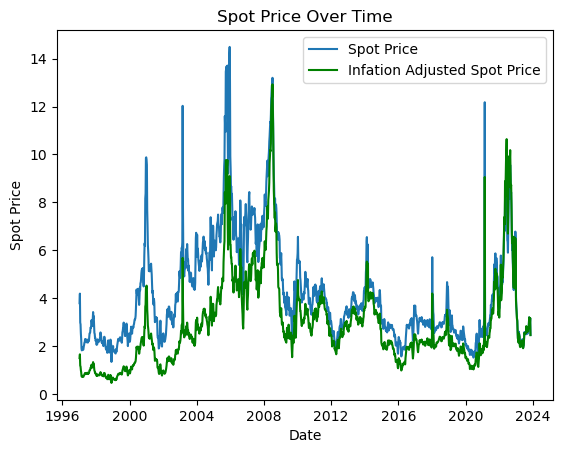

In [7]:
fig, axs = plt.subplots()
axs.plot(natural_gas_inf['date'], natural_gas_inf['spot_price'], label='Spot Price')
axs.plot(natural_gas_inf['date'], natural_gas_inf['spot_price_inf'], label='Infation Adjusted Spot Price', color='green')

axs.set_xlabel('Date')
axs.set_ylabel('Spot Price')
axs.set_title('Spot Price Over Time')
axs.legend()

We can see that adjusting for inflation mostly decreases prices, espeically for historical data. Adjusting for inflation will hopefully not over-predict spot prices based on higher spot prices than the adjusted spot prices.

In [8]:
mean_sp = natural_gas_inf['spot_price'].mean()
q1_so = natural_gas_inf['spot_price'].quantile(0.25)
median_sp = natural_gas_inf['spot_price'].quantile(0.5)
q3_sp = natural_gas_inf['spot_price'].quantile(0.75)

print('Spot Price')
print('Mean Price: $%.2f' %(mean_sp))
print('Q1 Price: $%.2f' %(q1_so))
print('Median Price: $%.2f' %(median_sp))
print('Q3 Price: $%.2f' %(q3_sp))
print('')

mean_sp = natural_gas_inf['spot_price_inf'].mean()
q1_so = natural_gas_inf['spot_price_inf'].quantile(0.25)
median_sp = natural_gas_inf['spot_price_inf'].quantile(0.5)
q3_sp = natural_gas_inf['spot_price_inf'].quantile(0.75)

print('Inflation Adjusted Spot Price')
print('Mean Price: $%.2f' %(mean_sp))
print('Q1 Price: $%.2f' %(q1_so))
print('Median Price: $%.2f' %(median_sp))
print('Q3 Price: $%.2f' %(q3_sp))

Spot Price
Mean Price: $4.20
Q1 Price: $2.64
Median Price: $3.54
Q3 Price: $5.27

Inflation Adjusted Spot Price
Mean Price: $2.91
Q1 Price: $1.76
Median Price: $2.42
Q3 Price: $3.53


Looking at the mean and various quantiles of prices, we also can see that the inflation adjusted spot prices are overall less than the non-inflation adjusted prices.

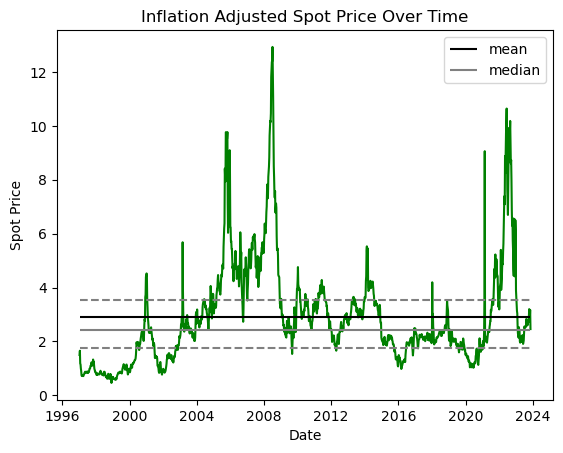

In [9]:
mean_sp = natural_gas_inf['spot_price_inf'].mean()
q1_so = natural_gas_inf['spot_price_inf'].quantile(0.25)
median_sp = natural_gas_inf['spot_price_inf'].quantile(0.5)
q3_sp = natural_gas_inf['spot_price_inf'].quantile(0.75)

max_date = natural_gas_inf['date'].max()
min_date = natural_gas_inf['date'].min()


fig, axs = plt.subplots()
axs.plot(natural_gas_inf['date'], natural_gas_inf['spot_price_inf'], color='green')
axs.hlines(mean_sp, min_date, max_date, color='black', label='mean')
axs.hlines(median_sp, min_date, max_date, color='grey', label='median')
axs.hlines(q1_so, min_date, max_date, color='grey', linestyles='dashed')
axs.hlines(q3_sp, min_date, max_date, color='grey', linestyles='dashed')


axs.set_xlabel('Date')
axs.set_ylabel('Spot Price')
axs.set_title('Inflation Adjusted Spot Price Over Time')
axs.legend()

We can plot just the spot price and the mean, meadian, and quartile values. As we can see from the above plot, spot price fluctuates, but tends to be relatively stable.

## Feature Engineering

As this data has only one feature, we can transform the data to add additional dimensions to aid in prediction. We can first add rolling mean prices in various increments.

It is important to ensure the rolling window does not take into account the current spot price, or else the model would be snooping on 'future' data.

In [10]:
# natural_gas_inf = natural_gas_inf.reset_index(inplace=True)
# natural_gas_inf = natural_gas_inf.set_index('date')
natural_gas_inf = natural_gas_inf.merge(natural_gas_inf[['date','spot_price_inf']].rolling('14D' ,on='date', axis=0, min_periods=1).mean(), \
                      how='left', on='date')
natural_gas_inf = natural_gas_inf.rename(columns={'spot_price_inf_x':'spot_price_inf', 'spot_price_inf_y':'2_week_rolling_avg'})
natural_gas_inf['2_week_rolling_avg'] = natural_gas_inf['2_week_rolling_avg'].shift(1)


natural_gas_inf = natural_gas_inf.merge(natural_gas_inf[['date','spot_price_inf']].rolling('28D' ,on='date', axis=0, min_periods=1).mean(), \
                      how='left', on='date')
natural_gas_inf = natural_gas_inf.rename(columns={'spot_price_inf_x':'spot_price_inf', 'spot_price_inf_y':'4_week_rolling_avg'})
natural_gas_inf['4_week_rolling_avg'] = natural_gas_inf['4_week_rolling_avg'].shift(1)


natural_gas_inf = natural_gas_inf.merge(natural_gas_inf[['date','spot_price_inf']].rolling('56D' ,on='date', axis=0, min_periods=1).mean(), \
                      how='left', on='date')
natural_gas_inf = natural_gas_inf.rename(columns={'spot_price_inf_x':'spot_price_inf', 'spot_price_inf_y':'8_week_rolling_avg'})
natural_gas_inf['8_week_rolling_avg'] = natural_gas_inf['8_week_rolling_avg'].shift(1)

natural_gas_inf['prev_price'] = natural_gas_inf['spot_price_inf'].shift(1)

In [11]:
natural_gas_inf

,date,spot_price,inflation,spot_price_inf,2_week_rolling_avg,4_week_rolling_avg,8_week_rolling_avg,prev_price
0,1997-01-10,3.79,0.395112,1.497475,NaN,NaN,NaN,None
1,1997-01-17,4.19,0.395112,1.65552,1.497475,1.497475,1.497475,1.497475
2,1997-01-24,2.98,0.395112,1.177434,1.576498,1.576498,1.576498,1.65552
3,1997-01-31,2.91,0.395112,1.149776,1.416477,1.443477,1.443477,1.177434
4,1997-02-07,2.53,0.394415,0.997869,1.163605,1.370052,1.370052,1.149776
...,...,...,...,...,...,...,...,...
1395,2023-10-13,3.2,1.0,3.2,2.827903,2.789435,2.708395,2.91
1396,2023-10-20,2.86,1.0,2.86,3.055000,2.890080,2.776094,3.2
1397,2023-10-27,2.89,1.0,2.89,3.030000,2.928951,2.808991,2.86
1398,2023-11-03,3.17,1.0,3.17,2.875000,2.965000,2.838628,2.89


We can see from the resulting dataframe that only the first row has NAN values. This is because there is no 'previous' value to average. We will exclude this row from the training set later on.

We can also add additional columns for various date dimensions. Adding in date parts, like month, quarter, and year, can help the model determine seasonal trends and yearly trends.

In [12]:
# Adding Date Parts as Columns
natural_gas_inf['month'] = natural_gas_inf['date'].apply(lambda x: x.month)
natural_gas_inf['quarter'] = natural_gas_inf['date'].apply(lambda x: x.quarter)
natural_gas_inf['year'] = natural_gas_inf['date'].apply(lambda x: x.year)

We can now calculate the correlation plot between these new dimensions.

In [13]:
natural_gas_inf.corr()

,date,spot_price,inflation,spot_price_inf,2_week_rolling_avg,4_week_rolling_avg,8_week_rolling_avg,prev_price,month,quarter,year
date,1.000000,-0.137307,0.826097,0.189714,0.191673,0.193627,0.197814,0.190223,0.025185,0.024067,0.999312
spot_price,-0.137307,1.000000,0.195646,0.896610,0.863616,0.850321,0.826259,0.869444,0.031304,0.029119,-0.138504
inflation,0.826097,0.195646,1.000000,0.554204,0.558781,0.562984,0.566945,0.555138,0.031359,0.028085,0.825165
spot_price_inf,0.189714,0.896610,0.554204,1.000000,0.973856,0.963913,0.942210,0.977401,0.038471,0.035941,0.188354
2_week_rolling_avg,0.191673,0.863616,0.558781,0.973856,1.000000,0.992704,0.971842,0.994348,0.044525,0.041332,0.190068
4_week_rolling_avg,0.193627,0.850321,0.562984,0.963913,0.992704,1.000000,0.987607,0.982706,0.043695,0.041666,0.192059
8_week_rolling_avg,0.197814,0.826259,0.566945,0.942210,0.971842,0.987607,1.000000,0.959889,0.045978,0.044945,0.196164
prev_price,0.190223,0.869444,0.555138,0.977401,0.994348,0.982706,0.959889,1.000000,0.044575,0.041264,0.188600
month,0.025185,0.031304,0.031359,0.038471,0.044525,0.043695,0.045978,0.044575,1.000000,0.971172,-0.011785
quarter,0.024067,0.029119,0.028085,0.035941,0.041332,0.041666,0.044945,0.041264,0.971172,1.000000,-0.011849


As we can see, the correlation between the various rolling averages is very high, which is unsurprising. The varioius averags are much less correlated with the date attributes, but are the most correlated with the yearly column. This makes sense because we expect most of the significant price changes are likely observed yearly. 

Overall, the model likely only needs one rolling average value, if it's needed at all. We can start by using the 4 week rolling average and adjusting if necessary.

## Build Pipeline

We can build a pipeline to transform our categorical variables (the date parts) and the numeric variables (the four week rolling average and date). 

We first must convert the date column to an ordinal number in order for the model not to treat the date as a categorical value. We can take the ordinal number in relation to weeks since the first recorded date.

In [14]:
# Ordinal Date
natural_gas_inf['date_ordinal'] = natural_gas_inf['date'].apply(lambda x: date.toordinal(x))

In [15]:
# Drop NANs
natural_gas_inf = natural_gas_inf.dropna(axis=0)

We can now build the full pipeline.

In [16]:
# Data Preprocessing
numeric_features = ['4_week_rolling_avg', 'date_ordinal']
numeric_transformer = Pipeline( # No missing values, so no need for an imputer
    steps=[('scaler', StandardScaler())]
)

categorical_features = ['month','quarter','year']
categorical_transformers = Pipeline(
    steps=[('scaler_2', StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformers, categorical_features)
    ]
)

pipeline = Pipeline(
    steps=[('preprocessor', preprocessor)]
)

## Train Test Split

Instead of randomly splitting the train and testing sets, we will instead choose to hold the last 20% of spot prices for testing. This mirrors the real world where the model needs to predict only future values.

In [17]:
natural_gas_inf = natural_gas_inf.sort_values(by='date').reset_index()
train = natural_gas_inf.loc[0:len(natural_gas_inf) - (len(natural_gas_inf) * 0.2)-1]
test = natural_gas_inf.loc[len(natural_gas_inf) - (len(natural_gas_inf) * 0.2):]

print('Training Set: ', len(train))
print('Testing Set: ', len(test))
print('Split Percent: ', len(test)/(len(train)+len(test))*100,'%')

Training Set:  1119
Testing Set:  279
Split Percent:  19.95708154506438 %


In [18]:
train_y = train['spot_price_inf']
test_y = test['spot_price_inf']

train_x = pipeline.fit_transform(train[['4_week_rolling_avg', 'month','quarter','year','date_ordinal']])
test_x = pipeline.transform(test[['4_week_rolling_avg', 'month','quarter','year','date_ordinal']])


## Model Evaluation

We can try various regressors from sklearn to fit our training data and predict the testing values. We will use the R2 and Explained Variance for fit metrics and Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE) as prediction metrics. We are able to use MAPE because there are no actual values (spot prices) that are zero. We can always expect values greater than zero for both predictions and actuals.

In [19]:
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor #non-neg positive=True
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

In [20]:
lr_model = LinearRegression(positive=True)
lr_model.fit(train_x, train_y)
lr_predict = lr_model.predict(test_x)
print('Linear Model')
print('R2 Score: ', r2_score(lr_predict, test_y))
print('Explained Variance: ', explained_variance_score(lr_predict, test_y))
print('MSE: ', mean_squared_error(lr_predict, test_y))
print('MAPE: ', mean_absolute_percentage_error(lr_predict, test_y), '%')
print('')

r_model = Ridge()
r_model.fit(train_x, train_y)
r_predict = r_model.predict(test_x)
print('Ridge Model')
print('R2 Score: ', r2_score(r_predict, test_y))
print('Explained Variance: ', explained_variance_score(r_predict, test_y))
print('MSE: ', mean_squared_error(r_predict, test_y))
print('MAPE: ', mean_absolute_percentage_error(r_predict, test_y), '%')
print('')

sgd_model = SGDRegressor()
sgd_model.fit(train_x, train_y)
sgd_predict = sgd_model.predict(test_x)
print('SGD Model')
print('R2 Score: ', r2_score(sgd_predict, test_y))
print('Explained Variance: ', explained_variance_score(sgd_predict, test_y))
print('MSE: ', mean_squared_error(sgd_predict, test_y))
print('MAPE: ', mean_absolute_percentage_error(sgd_predict, test_y), '%')
print('')

svr_model = SVR(kernel='linear')
svr_model.fit(train_x, train_y)
svr_predict = svr_model.predict(test_x)
print('SVR Model')
print('R2 Score: ', r2_score(svr_predict, test_y))
print('Explained Variance: ', explained_variance_score(svr_predict, test_y))
print('MSE: ', mean_squared_error(svr_predict, test_y))
print('MAPE: ', mean_absolute_percentage_error(svr_predict, test_y), '%')
print('')

dt_model = DecisionTreeRegressor()
dt_model.fit(train_x, train_y)
dt_predict = dt_model.predict(test_x)
print('DT Model')
print('R2 Score: ', r2_score(dt_predict, test_y))
print('Explained Variance: ', explained_variance_score(dt_predict, test_y))
print('MSE: ', mean_squared_error(dt_predict, test_y))
print('MAPE: ', mean_absolute_percentage_error(dt_predict, test_y), '%')
print('')

gbr_model = GradientBoostingRegressor()
gbr_model.fit(train_x, train_y)
gbr_predict = gbr_model.predict(test_x)
print('GBR Model')
print('R2 Score: ', r2_score(gbr_predict, test_y))
print('Explained Variance: ', explained_variance_score(gbr_predict, test_y))
print('MSE: ', mean_squared_error(gbr_predict, test_y))
print('MAPE: ', mean_absolute_percentage_error(gbr_predict, test_y), '%')
print('')

abr_model = AdaBoostRegressor()
abr_model.fit(train_x, train_y)
abr_predict = abr_model.predict(test_x)
print('ABR Model')
print('R2 Score: ', r2_score(abr_predict, test_y))
print('Explained Variance: ', explained_variance_score(abr_predict, test_y))
print('MSE: ', mean_squared_error(abr_predict, test_y))
print('MAPE: ', mean_absolute_percentage_error(abr_predict, test_y), '%')
print('')

Linear Model
R2 Score:  0.8659888839421176
Explained Variance:  0.8659962175215565
MSE:  0.5539276910348315
MAPE:  0.1166230431517775 %

Ridge Model
R2 Score:  0.8653213114260554
Explained Variance:  0.8653322119911879
MSE:  0.555900354339198
MAPE:  0.11804571330243194 %

SGD Model
R2 Score:  0.8653333083555871
Explained Variance:  0.8653846962653181
MSE:  0.5551462735997426
MAPE:  0.11684135858066252 %

SVR Model
R2 Score:  0.8684036743031867
Explained Variance:  0.8686272502812704
MSE:  0.5592030489472042
MAPE:  0.11961196883869504 %

DT Model
R2 Score:  0.7996463636341851
Explained Variance:  0.8003998955611449
MSE:  0.7359502963035613
MAPE:  0.164906156229634 %

GBR Model
R2 Score:  0.7829375633679315
Explained Variance:  0.7881995102711575
MSE:  0.6599324656153797
MAPE:  0.13270916177164374 %

ABR Model
R2 Score:  0.822822387279977
Explained Variance:  0.8344717894122089
MSE:  0.6338089192395995
MAPE:  0.16736115879824623 %



Overall, the models performed pretty well. The Linear model, only specifying a non-negative linear model, had an R2 score of 0.866 and MAPE of 0.117. The worse performing model was the Gradient Boosted Regression model with an R2 of 0.776 and MAPE of 0.135, which is still fairly good. The best performing model was the SVR model with a linear kernel. 

We can evaluate the Linear model and the SVR model more in depth.

Text(0, 0.5, 'Actual')

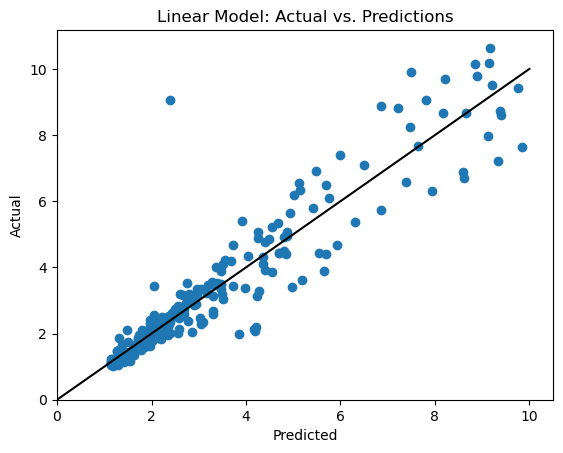

In [21]:
xy_x = range(0,11,1)
xy_y = range(0,11,1)
fig, ax = plt.subplots()
ax.scatter(lr_predict, test_y)
ax.plot(xy_x, xy_y, color='black')
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_title('Linear Model: Actual vs. Predictions')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

Text(0, 0.5, 'Actual')

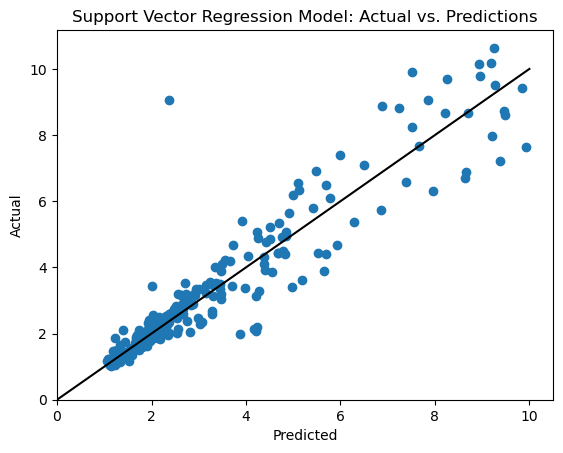

In [22]:
xy_x = range(0,11,1)
xy_y = range(0,11,1)
fig, ax = plt.subplots()
ax.scatter(svr_predict, test_y)
ax.plot(xy_x, xy_y, color='black')
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_title('Support Vector Regression Model: Actual vs. Predictions')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

When we plot predictions vs. actuals, we see a similar pattern: at lower prices, predictions and actuals are very close, but at higher prices, predictions and actuals differ, but the predictions are split between over predicting and under predicting.

Around the predicted value of 42 there seem to be two points very far from the line y=x (or predictions = actuals), one of which is in actuality much higher than 4.

Text(0, 0.5, 'Price')

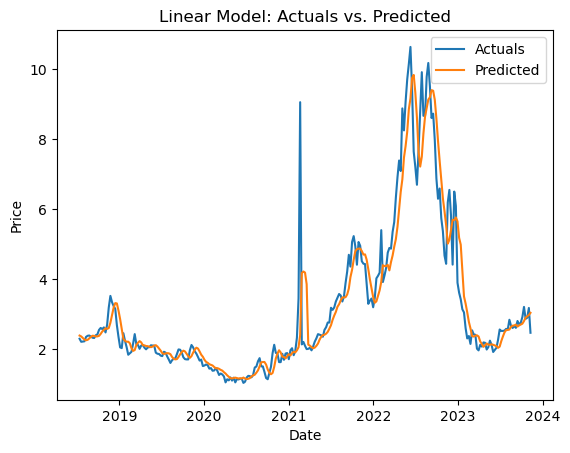

In [23]:
dates = test['date']

fig, ax = plt.subplots()
ax.plot(dates, test_y, label='Actuals')
ax.plot(dates, lr_predict, label='Predicted')
ax.legend()
ax.set_title('Linear Model: Actuals vs. Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

Text(0, 0.5, 'Price')

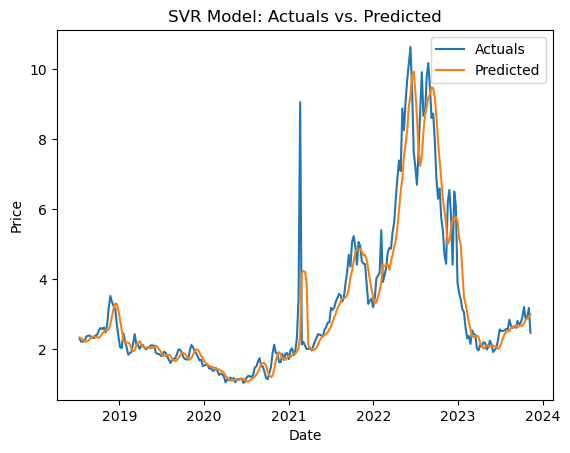

In [24]:
fig, ax = plt.subplots()
ax.plot(dates, test_y, label='Actuals')
ax.plot(dates, svr_predict, label='Predicted')
ax.legend()
ax.set_title('SVR Model: Actuals vs. Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

In [25]:
lr_model.coef_

array([1.79160711e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.34136661e-03])

In [26]:
svr_model.coef_

array([[ 1.81786274, -0.02265806,  0.05588361, -0.06351241,  0.01449046]])

Plotting the predictions and actuals over time shows exactly what this model is doing. We see that the model is more or less relying soly on the 4 Week Rolling Average to make the predictions. This means the predictions are a time shifted, smoothed version of the 4 week moving average. Overall, this makes the fit failry good, but the predictions can be wildly off, especially if there is a large spike in price, like the spike around early 2021.

## ARMA and ARIMA

Instad of making a prediction based on the 4 week moving average (or any other moving average), we can instead try to use Autoregressive Moving Average (ARMA) and Autoregressive Integrated Moving Average modeling techniques to predict this data.

***References:***
- https://www.machinelearningplus.com/time-series/time-series-analysis-python/
- https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

In [27]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose

Text(0.5, 1, 'Additive')

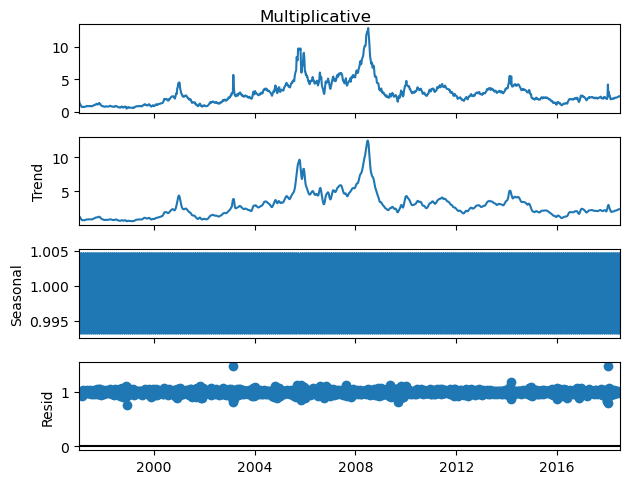

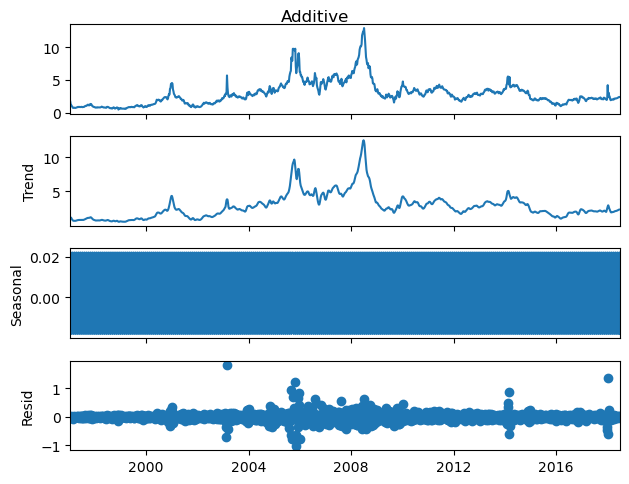

In [28]:
train_dates = pd.DatetimeIndex(train['date'].values, freq='infer')
train_values = train['spot_price_inf'].values.astype(float)
ts = pd.DataFrame(train_values, index=train_dates, columns=['spot_price_inf'])
result_mul = seasonal_decompose(ts.asfreq('W-FRI').dropna(), model='multiplicative', period=4)
result_add = seasonal_decompose(ts.asfreq('W-FRI').dropna(), model='additive', period=4)

result_mul.plot().suptitle('Multiplicative', y=1)
result_add.plot().suptitle('Additive', y=1)

We can see by the trend decomposition graphs that there does not seem to be any obvious trends, but we can still fit the ARMIA models and plot the predictions.

We can fit the model with a (1,0,1) order model, or a first order Autoregressive and Moving Average Model.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1119
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -220.281
Date:                Sun, 24 Dec 2023   AIC                            448.563
Time:                        11:24:46   BIC                            468.644
Sample:                    01-17-1997   HQIC                           456.153
                         - 06-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7732      0.917      3.025      0.002       0.977       4.570
ar.L1          0.9846      0.004    265.261      0.000       0.977       0.992
ma.L1          0.0773      0.011      6.905      0.0

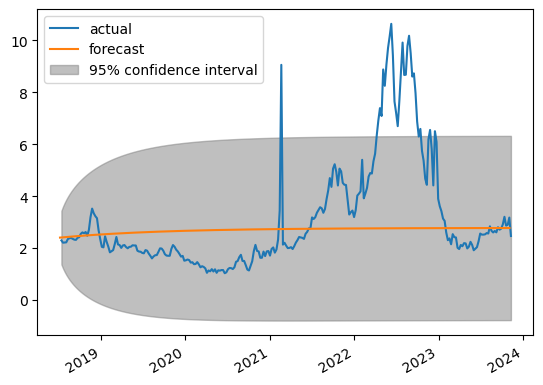

In [29]:
train_dates = pd.DatetimeIndex(train['date'].values).to_period('W-FRI')
train_values = train['spot_price_inf'].values.astype(float)
ts = pd.Series(train_values, index=train_dates)
arma_model = ARIMA(ts, order=(1,0,1))
arma_res = arma_model.fit()
print(arma_res.summary())

fig, ax = plt.subplots()
ax.plot(test['date'], test['spot_price_inf'], label='actual')
fig = plot_predict(arma_res, start='2018-07-13', end='2023-11-10', ax=ax)
legend = ax.legend()

Unfortunatly, since the ARMIA model could not determine trends, the model is very basic and the confidence interval does not capture the spikes in data around 2022-2023.

## XGBoost

We can try one more modeling technique, XGBoost. XGBoost is another ensemble method and can be used for time series forecasting.

***References:***
- https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
- https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [32]:
import xgboost

In [33]:
xgb_model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb_model.fit(train_x, train_y)
xgb_predict = xgb_model.predict(test_x)

print('XGB Model')
print('R2 Score: ', r2_score(xgb_predict, test_y))
print('Explained Variance: ', explained_variance_score(xgb_predict, test_y))
print('MSE: ', mean_squared_error(xgb_predict, test_y))
print('MAPE: ', mean_absolute_percentage_error(xgb_predict, test_y), '%')
print('')

XGB Model
R2 Score:  0.3291877891073315
Explained Variance:  0.3750278195181632
MSE:  1.1987879121383782
MAPE:  0.20415018788363182 %



Text(0, 0.5, 'Actual')

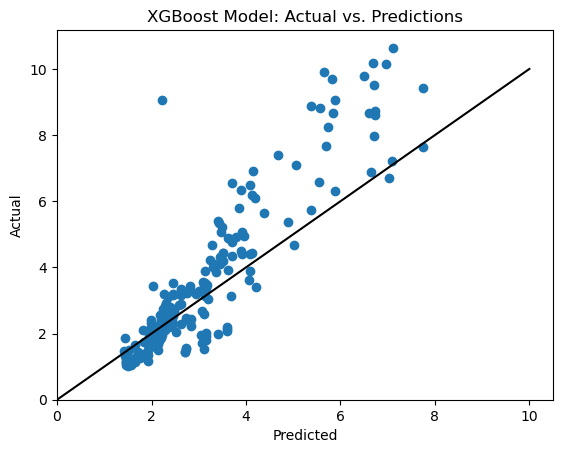

In [34]:
xy_x = range(0,11,1)
xy_y = range(0,11,1)
fig, ax = plt.subplots()
ax.scatter(xgb_predict, test_y)
ax.plot(xy_x, xy_y, color='black')
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_title('XGBoost Model: Actual vs. Predictions')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

Text(0, 0.5, 'Price')

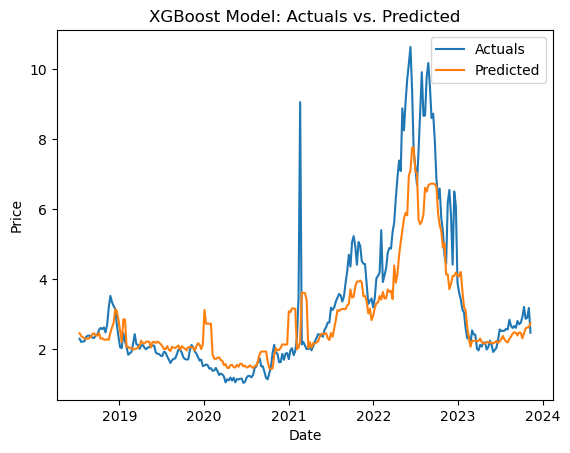

In [35]:
dates = test['date']

fig, ax = plt.subplots()
ax.plot(dates, test_y, label='Actuals')
ax.plot(dates, xgb_predict, label='Predicted')
ax.legend()
ax.set_title('XGBoost Model: Actuals vs. Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

We can see that the XGBoost model is predicting much different values from the acutal value. The overall R2 and MAPE metrics for the model are much worse than previous models, which is not suprising seeing the Predicted vs. Actuals graphs.

The model seems to under-predict when the spot price is relatively high, but over-predicts when the spot price is low.

## Actual Future Spot Price Evaluation

With no consensus for which model would preform the best, we can examine the Linear, SVR, and XGBoost predictions for the future values.

A special prediction function must be created in order to predict multiple periods into the future, while taking into account previous period predictions. This will be done by iteratively predicting each time step and taking the model prediction as the 'actual' in subsequent steps.

In [161]:
# Prediction Function (4 Week Rolling Average)
def predict_prices(period, model, pipeline, org_data):
    copy_data = org_data.copy()
    copy_data = copy_data[['date', 'spot_price', '4_week_rolling_avg','month','quarter','year', 'date_ordinal']]
    copy_data['prediction/actual'] = 'actual'
    max_date = copy_data['date'].max()
    max_date_ordinal = copy_data['date_ordinal'].max()
    date_dict = {}
    for i in range(period):
        add = (i+1)*7
        new_date_ordinal = max_date_ordinal + add
        new_date = max_date + timedelta(days=add)
        date_dict[new_date_ordinal] = new_date
    for key in date_dict:
        c_month = date_dict[key].month
        c_quarter = date_dict[key].quarter
        c_year =  date_dict[key].year
        c_4_week_avg = copy_data[(copy_data['date_ordinal'] < key) & (copy_data['date_ordinal'] >= (key-28))]['spot_price'].mean()
        d = {'date': date_dict[key], '4_week_rolling_avg':c_4_week_avg, \
             'month':c_month, 'quarter':c_quarter, 'year':c_year, 'date_ordinal':key}
        temp_df = pd.DataFrame(d, index=[0])
        test_x = pipeline.transform(temp_df)
        predict = model.predict(test_x)
        d2 = {'date': date_dict[key], '4_week_rolling_avg':c_4_week_avg, \
             'month':c_month, 'quarter':c_quarter, 'year':c_year, 'date_ordinal':key, \
              'spot_price':round(predict[0],2), 'prediction/actual':'prediction'}
        add_df = pd.DataFrame(d2, index=[0])
        copy_data = pd.concat([copy_data, add_df], ignore_index=True)
    return copy_data 

In [164]:
predict_prices(2, xgb_model, pipeline, natural_gas_inf)

,date,spot_price,4_week_rolling_avg,month,quarter,year,date_ordinal,prediction/actual
0,1997-01-17,4.19,1.497475,1,1,1997,729041,actual
1,1997-01-24,2.98,1.576498,1,1,1997,729048,actual
2,1997-01-31,2.91,1.443477,1,1,1997,729055,actual
3,1997-02-07,2.53,1.370052,2,1,1997,729062,actual
4,1997-02-14,2.3,1.245150,2,1,1997,729069,actual
...,...,...,...,...,...,...,...,...
1396,2023-10-27,2.89,2.928951,10,4,2023,738820,actual
1397,2023-11-03,3.17,2.965000,11,4,2023,738827,actual
1398,2023-11-10,2.46,3.030000,11,4,2023,738834,actual
1399,2023-11-17,2.43,2.845000,11,4,2023,738841,prediction


We can see the output is a dataframe with actual and prediction values. While the model does not need all data, we can return the full dataframe, as it is fairly small.

We can now assess the actual week ending spot prices. We could re-download the data, but because we are only looking at a few periods, we can just copy the data directly from the Spot Price [website](https://www.eia.gov/dnav/ng/hist/rngwhhdw.htm), previously cited.

In [181]:
y_actual = {'date':[date(2023,11,17),date(2023,11,24),date(2023,12,1),date(2023,12,8),date(2023,12,15)],
            'spot_price':[2.74,2.64,2.72,2.62,2.38], 'prediction/actual':['actual','actual','actual','actual','actual']}
y_actual_df = pd.DataFrame(y_actual)
y_actual_df['date'] = y_actual_df['date'].apply(lambda x: pd.to_datetime(x))
y_actual_df

,date,spot_price,prediction/actual
0,2023-11-17,2.74,actual
1,2023-11-24,2.64,actual
2,2023-12-01,2.72,actual
3,2023-12-08,2.62,actual
4,2023-12-15,2.38,actual


We can now predict the next 5 weeks of data for the Linear Regressor, SVR, and XGBoost model.

In [202]:
lr_predict_df = predict_prices(5, lr_model, pipeline, natural_gas_inf)
svr_predict_df = predict_prices(5, svr_model, pipeline, natural_gas_inf)
xgb_predict_df = predict_prices(5, xgb_model, pipeline, natural_gas_inf)

lr_predict_df_full = pd.concat([lr_predict_df,y_actual_df])
svr_predict_df_full = pd.concat([svr_predict_df,y_actual_df])
xgb_predict_df_full = pd.concat([xgb_predict_df,y_actual_df])

Mean Squared Error: 0.06
Mean Absolute Percent Error: 0.08


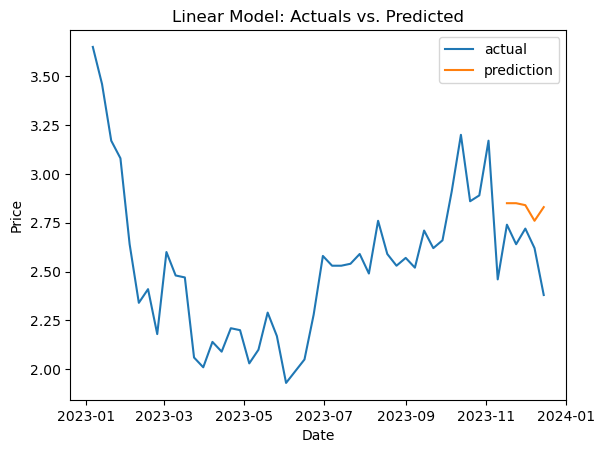

In [211]:
fig, ax = plt.subplots()
df = lr_predict_df_full[lr_predict_df_full['date'] >= pd.to_datetime(date(2023,1,1))]
ax.plot(df[df['prediction/actual']=='actual']['date'], df[df['prediction/actual']=='actual']['spot_price'], label='actual')
ax.plot(df[df['prediction/actual']=='prediction']['date'], df[df['prediction/actual']=='prediction']['spot_price'], label='prediction')
ax.legend()
ax.set_title('Linear Model: Actuals vs. Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

y_actuals = y_actual_df['spot_price'].values
y_predict = lr_predict_df[lr_predict_df['prediction/actual']=='prediction']['spot_price'].values

print('Mean Squared Error: %.2f'%(mean_squared_error(y_actuals, y_predict)))
print('Mean Absolute Percent Error: %.2f'%(mean_absolute_percentage_error(y_actuals, y_predict)),'%')

Mean Squared Error: 0.03
Mean Absolute Percent Error: 0.05 %


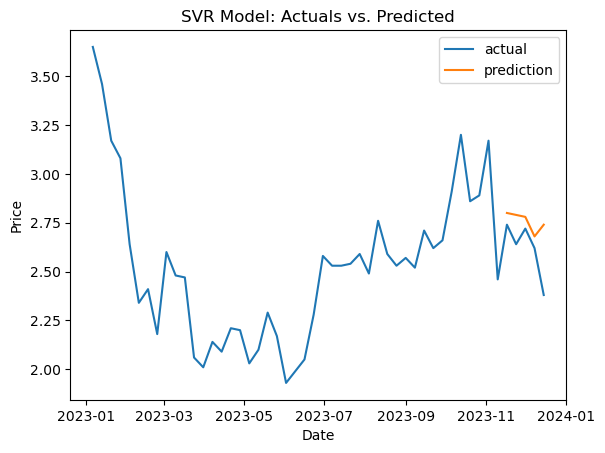

In [212]:
fig, ax = plt.subplots()
df = svr_predict_df_full[svr_predict_df_full['date'] >= pd.to_datetime(date(2023,1,1))]
ax.plot(df[df['prediction/actual']=='actual']['date'], df[df['prediction/actual']=='actual']['spot_price'], label='actual')
ax.plot(df[df['prediction/actual']=='prediction']['date'], df[df['prediction/actual']=='prediction']['spot_price'], label='prediction')
ax.legend()
ax.set_title('SVR Model: Actuals vs. Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

y_actuals = y_actual_df['spot_price'].values
y_predict = svr_predict_df[svr_predict_df['prediction/actual']=='prediction']['spot_price'].values

print('Mean Squared Error: %.2f'%(mean_squared_error(y_actuals, y_predict)))
print('Mean Absolute Percent Error: %.2f'%(mean_absolute_percentage_error(y_actuals, y_predict)),'%')

Mean Squared Error: 0.11
Mean Absolute Percent Error: 0.11 %


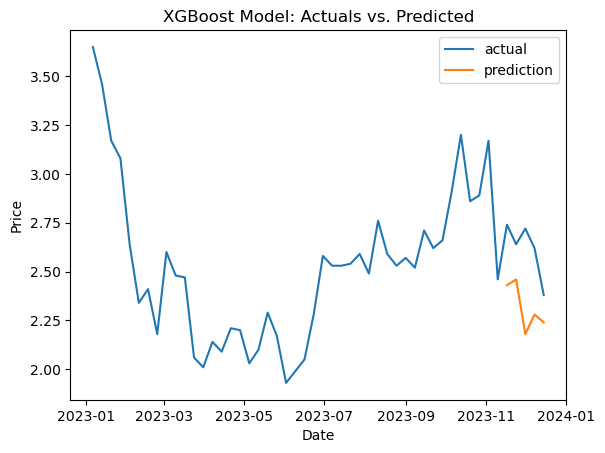

In [213]:
fig, ax = plt.subplots()
df = xgb_predict_df_full[xgb_predict_df_full['date'] >= pd.to_datetime(date(2023,1,1))]
ax.plot(df[df['prediction/actual']=='actual']['date'], df[df['prediction/actual']=='actual']['spot_price'], label='actual')
ax.plot(df[df['prediction/actual']=='prediction']['date'], df[df['prediction/actual']=='prediction']['spot_price'], label='prediction')
ax.legend()
ax.set_title('XGBoost Model: Actuals vs. Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

y_actuals = y_actual_df['spot_price'].values
y_predict = xgb_predict_df[xgb_predict_df['prediction/actual']=='prediction']['spot_price'].values

print('Mean Squared Error: %.2f'%(mean_squared_error(y_actuals, y_predict)))
print('Mean Absolute Percent Error: %.2f'%(mean_absolute_percentage_error(y_actuals, y_predict)),'%')

# Conclusion and Reflections

Overall, the SVR model did the best at predicting future prices for multiple future periods. This is not suprising given that the model performed the best against the testing data. While the first two models overpredicted the spot price, the XGBoost model underpredicted the spot price. However, the XGBoost predicted a closer price during the final period, where the spot price took a dramatic decrease, compared to the first two models.

This project was very interesting to complete. There are a lot of things to take into account with predicting time series data, including how past data should be incorporated as well as how to predict multiple periods in the future. I am happy with the skills I gained completing this project even if the overall model results could be better. 

Future improvements can be made by incorporating or testing various rolling average ranges or trying advanced time series data techniques, as the first two models are too dependent on the single rolling-average spot price column. Additionally, finding a way to output confidence intervals similar to the ARMA model would be helpful, as it's unlikely these models will predict the exact spot price.